In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a3743bcb34275330c0fb510a8b55077e5c69391c3ea606d842f0d0b0e011a428
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


###***Importacion de librerias***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pyarrow
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.window import Window
from pyspark.sql.functions import min, max
from pyspark.sql.functions import hour
from pyspark.sql.functions import to_timestamp, round
from pyspark.sql import SparkSession
from functools import reduce


**Lee y carga el Archivo**

In [ ]:
# Crea una sesión de Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Ruta de la carpeta que contiene los archivos Parquet
ruta = "/content/drive/MyDrive/Proyecto FInal Henry/datos_tripdata/"

# Lista para almacenar los DataFrames de cada archivo
dfs = []

# Itera sobre los años 2022 y 2023 y sobre todos los meses
for year in range(2022, 2024):
    for month in range(1, 13):
        filename = f"yellow_tripdata_{year}-{month:02d}.parquet"
        try:
            df = spark.read.parquet(ruta + filename)
            dfs.append(df)
        except:
            print(f"No se encontró el archivo {filename}")


df_total = reduce(lambda df1, df2: df1.union(df2), dfs)
df_total.printSchema()
df_total.show()


root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+----

In [ ]:
'''

# Número de filas
num_rows = df_total.count()

# Número de columnas
num_cols = len(df_total.columns)

print("Número de filas:", num_rows)
print("Número de columnas:", num_cols)

'''


'\n\n# Número de filas\nnum_rows = df_total.count()\n\n# Número de columnas\nnum_cols = len(df_total.columns)\n\nprint("Número de filas:", num_rows)\nprint("Número de columnas:", num_cols)\n\n'

**Verifica las fechas de los datos**

In [ ]:
'''

# Obtener los valores mínimo y máximo de la columna 'date_only'
min_date = df_total.select(min('tpep_pickup_datetime')).first()[0]
max_date = df_total.select(max('tpep_pickup_datetime')).first()[0]

# Mostrar los valores mínimo y máximo
print("Valor mínimo de 'date_only':", min_date)
print("Valor máximo de 'date_only':", max_date)

'''

'\n\n# Obtener los valores mínimo y máximo de la columna \'date_only\'\nmin_date = df_total.select(min(\'tpep_pickup_datetime\')).first()[0]\nmax_date = df_total.select(max(\'tpep_pickup_datetime\')).first()[0]\n\n# Mostrar los valores mínimo y máximo\nprint("Valor mínimo de \'date_only\':", min_date)\nprint("Valor máximo de \'date_only\':", max_date)\n\n'

**Filtra solo las columnas necesarias para ML**

In [ ]:
df_total = df_total [['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'total_amount', 'congestion_surcharge', 'airport_fee']]

In [ ]:
'''

# Cantidad de filas
num_filas = df_total.count()

# Cantidad de columnas
num_columnas = len(df_total.columns)

# Imprimir la cantidad de filas y columnas
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)

'''

'\n\n# Cantidad de filas\nnum_filas = df_total.count()\n\n# Cantidad de columnas\nnum_columnas = len(df_total.columns)\n\n# Imprimir la cantidad de filas y columnas\nprint("Cantidad de filas:", num_filas)\nprint("Cantidad de columnas:", num_columnas)\n\n'

**Crea la columna 'date_only' solo con el valor de la fecha para hacer un merge**

In [ ]:
# Convierte la columna 'tpep_pickup_datetime' a tipo timestamp
df_total = df_total.withColumn('tpep_pickup_datetime', F.to_timestamp(df_total['tpep_pickup_datetime']))

# Extrae la parte de la fecha y asigna a una nueva columna 'date_only'
df_total = df_total.withColumn('date_only', F.to_date(df_total['tpep_pickup_datetime']))

# Muestra el DataFrame con la nueva columna 'date_only'
#df_total.show()

**DATOS DEL TIEMPO**

**Lee y carga el archivo**

In [ ]:
# Especifica la ruta del archivo CSV en Google Drive
ruta_archivo_csv = '/content/drive/MyDrive/Proyecto FInal Henry/DATA*/daily_weather_data.csv'

# Leer el archivo CSV en un DataFrame de PySpark
daily_weather_data = spark.read.csv(ruta_archivo_csv, header=True, inferSchema=True)

# Mostrar el DataFrame
daily_weather_data.show()

+-------------------+------------------+------------------+-------------------+-----------------+
|               date|temperature_2m_max|temperature_2m_min|temperature_2m_mean|precipitation_sum|
+-------------------+------------------+------------------+-------------------+-----------------+
|2010-01-01 04:00:00|            5.3305|           -4.0695|         0.29091665|        1.8000001|
|2010-01-02 04:00:00|       -0.86950004|           -9.3695|         -3.5465834|              0.7|
|2010-01-03 04:00:00|        -4.8694997|          -10.1195|         -7.6820006|              0.0|
|2010-01-04 04:00:00|           -0.7195|           -7.3195|          -4.873667|              0.0|
|2010-01-05 04:00:00|      -0.119500004|        -7.3694997|         -4.6486664|              0.0|
|2010-01-06 04:00:00|            1.1805|        -5.3694997|         -2.8653333|              0.0|
|2010-01-07 04:00:00|            3.6805|           -3.8195|         -1.2924166|              0.0|
|2010-01-08 04:00:00

**Verifica cantidad de filas y columnas**

In [ ]:
'''

# Cantidad de filas
num_filas = daily_weather_data.count()

# Cantidad de columnas
num_columnas = len(daily_weather_data.columns)

# Imprimir la cantidad de filas y columnas
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)

'''

'\n\n# Cantidad de filas\nnum_filas = daily_weather_data.count()\n\n# Cantidad de columnas\nnum_columnas = len(daily_weather_data.columns)\n\n# Imprimir la cantidad de filas y columnas\nprint("Cantidad de filas:", num_filas)\nprint("Cantidad de columnas:", num_columnas)\n\n'

**Verifica las fechas cargadas**

In [ ]:
'''

# Obtener los valores mínimo y máximo de la columna 'date_only'
min_date = daily_weather_data.select(min('date')).first()[0]
max_date = daily_weather_data.select(max('date')).first()[0]

# Mostrar los valores mínimo y máximo
print("Valor mínimo de 'date_only':", min_date)
print("Valor máximo de 'date_only':", max_date)

'''

'\n\n# Obtener los valores mínimo y máximo de la columna \'date_only\'\nmin_date = daily_weather_data.select(min(\'date\')).first()[0]\nmax_date = daily_weather_data.select(max(\'date\')).first()[0]\n\n# Mostrar los valores mínimo y máximo\nprint("Valor mínimo de \'date_only\':", min_date)\nprint("Valor máximo de \'date_only\':", max_date)\n\n'

**Filtra el dataframe con la columnasnecesarias para el ML**

In [ ]:
daily_weather_data = daily_weather_data [['date', 'temperature_2m_mean', 'precipitation_sum']]
daily_weather_data.show()

+-------------------+-------------------+-----------------+
|               date|temperature_2m_mean|precipitation_sum|
+-------------------+-------------------+-----------------+
|2010-01-01 04:00:00|         0.29091665|        1.8000001|
|2010-01-02 04:00:00|         -3.5465834|              0.7|
|2010-01-03 04:00:00|         -7.6820006|              0.0|
|2010-01-04 04:00:00|          -4.873667|              0.0|
|2010-01-05 04:00:00|         -4.6486664|              0.0|
|2010-01-06 04:00:00|         -2.8653333|              0.0|
|2010-01-07 04:00:00|         -1.2924166|              0.0|
|2010-01-08 04:00:00|         -1.5611666|       0.70000005|
|2010-01-09 04:00:00|          -5.654917|              0.0|
|2010-01-10 04:00:00|         -6.7007504|              0.0|
|2010-01-11 04:00:00|         -4.1486664|              0.0|
|2010-01-12 04:00:00|          -2.254917|              0.0|
|2010-01-13 04:00:00|         -2.9236662|              0.0|
|2010-01-14 04:00:00|         -0.8174166

**Crea la columna 'date_only' solo con el valor de la fecha para hacer un merge**

In [ ]:
# Convierte la columna 'date' a tipo timestamp
daily_weather_data = daily_weather_data.withColumn('date', F.to_timestamp(daily_weather_data['date']))

# Extrae la parte de la fecha y asigna a una nueva columna 'date_only'
daily_weather_data = daily_weather_data.withColumn('date_only', F.to_date(daily_weather_data['date']))

# Muestra el DataFrame con la nueva columna 'date_only'
#daily_weather_data.show()

**Realiza la union de ambos dataframes**

In [ ]:
# Realizar la unión de DataFrames en PySpark
merged_df = df_total.join(daily_weather_data, on='date_only', how='left')

# Mostrar el DataFrame resultante
#merged_df.show()


**Verifica cantidad de filas y columnas**

In [ ]:
'''

# Cantidad de filas
num_filas = merged_df.count()

# Cantidad de columnas
num_columnas = len(merged_df.columns)

# Imprimir la cantidad de filas y columnas
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)

'''

'\n\n# Cantidad de filas\nnum_filas = merged_df.count()\n\n# Cantidad de columnas\nnum_columnas = len(merged_df.columns)\n\n# Imprimir la cantidad de filas y columnas\nprint("Cantidad de filas:", num_filas)\nprint("Cantidad de columnas:", num_columnas)\n\n'

**Imputacion de nulos**

In [ ]:
# Reemplazar los valores nulos en la columna 'passenger_count' con 1
merged_df = merged_df.withColumn('passenger_count', when(merged_df['passenger_count'].isNull(), 1).otherwise(merged_df['passenger_count']))

# Reemplazar los valores nulos en la columna 'congestion_surcharge' con 0
merged_df = merged_df.withColumn('congestion_surcharge', when(merged_df['congestion_surcharge'].isNull(), 0).otherwise(merged_df['congestion_surcharge']))

# Reemplazar los valores nulos en la columna 'airport_fee' con 0
merged_df = merged_df.withColumn('airport_fee', when(merged_df['airport_fee'].isNull(), 0).otherwise(merged_df['airport_fee']))

# Mostrar el DataFrame resultante
#merged_df.show()


In [ ]:
'''
# Verificar si hay valores nulos en el DataFrame
valores_nulos = merged_df.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in merged_df.columns]).collect()

# Comprobar si hay al menos un valor nulo en cualquier columna
if any(valores_nulos[0]):
    print("El DataFrame merged_df tiene valores nulos.")
else:
    print("El DataFrame merged_df no tiene valores nulos.")

'''

'\n# Verificar si hay valores nulos en el DataFrame\nvalores_nulos = merged_df.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in merged_df.columns]).collect()\n\n# Comprobar si hay al menos un valor nulo en cualquier columna\nif any(valores_nulos[0]):\n    print("El DataFrame merged_df tiene valores nulos.")\nelse:\n    print("El DataFrame merged_df no tiene valores nulos.")\n\n'

**Elimina filas con valores nulos**

In [ ]:
# Eliminar filas con valores nulos
merged_df_sin_nulos = merged_df.na.drop()

In [ ]:
'''
# Verificar si hay valores nulos en el DataFrame
valores_nulos = merged_df_sin_nulos.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in merged_df_sin_nulos.columns]).collect()

# Comprobar si hay al menos un valor nulo en cualquier columna
if any(valores_nulos[0]):
    print("El DataFrame merged_df tiene valores nulos.")
else:
    print("El DataFrame merged_df no tiene valores nulos.")

'''

'\n# Verificar si hay valores nulos en el DataFrame\nvalores_nulos = merged_df_sin_nulos.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in merged_df_sin_nulos.columns]).collect()\n\n# Comprobar si hay al menos un valor nulo en cualquier columna\nif any(valores_nulos[0]):\n    print("El DataFrame merged_df tiene valores nulos.")\nelse:\n    print("El DataFrame merged_df no tiene valores nulos.")\n\n'

In [ ]:
'''
# Cantidad de filas
num_filas = merged_df_sin_nulos.count()

# Cantidad de columnas
num_columnas = len(merged_df_sin_nulos.columns)

# Imprimir la cantidad de filas y columnas
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)
'''

'\n# Cantidad de filas\nnum_filas = merged_df_sin_nulos.count()\n\n# Cantidad de columnas\nnum_columnas = len(merged_df_sin_nulos.columns)\n\n# Imprimir la cantidad de filas y columnas\nprint("Cantidad de filas:", num_filas)\nprint("Cantidad de columnas:", num_columnas)\n'

**Convierte las columnas de precipitaciones, congestion y aeropuerto en 0 si no ocurrió el evento y 1 si ocurrió**

In [ ]:
# Reemplazar los valores distintos de cero por 1 en la columna 'temperature_2m_mean'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('precipitation_sum', when(merged_df_sin_nulos['precipitation_sum'] != 0, 1).otherwise(0))

# Reemplazar los valores distintos de cero por 1 en la columna 'congestion_surcharge'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('congestion_surcharge', when(merged_df_sin_nulos['congestion_surcharge'] != 0, 1).otherwise(0))

# Reemplazar los valores distintos de cero por 1 en la columna 'airport_fee'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('airport_fee', when(merged_df_sin_nulos['airport_fee'] != 0, 1).otherwise(0))

# Mostrar el DataFrame resultante
#merged_df_sin_nulos.show()

**MODIFICANDO GRANULARIDAD DE LOS DATOS**

**Crea la columna franja horaria a partir de la hora de iniciado el viaje 'tpep_pickup_datetime'**

In [ ]:
# Convertir la columna 'tpep_pickup_datetime' a tipo timestamp
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('tpep_pickup_datetime', F.to_timestamp(merged_df_sin_nulos['tpep_pickup_datetime']))

# Extraer la hora de la columna 'tpep_pickup_datetime' y asignarla a la nueva columna 'franja_horaria'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('franja_horaria', hour(merged_df_sin_nulos['tpep_pickup_datetime']))

# Mostrar el DataFrame resultante
#merged_df_sin_nulos.show()


**Calcula la duración del viaje en minutos restando las columnas de inicio y fin del viaje**

In [ ]:
# Convertir las columnas 'tpep_pickup_datetime' y 'tpep_dropoff_datetime' a tipo datetime si no lo están
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('tpep_pickup_datetime', to_timestamp(merged_df_sin_nulos['tpep_pickup_datetime']))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('tpep_dropoff_datetime', to_timestamp(merged_df_sin_nulos['tpep_dropoff_datetime']))

# Calcular la duración del viaje en minutos y redondear el resultado a 2 decimales
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('duracion_viaje_minutos',
                                                     round(((F.col('tpep_dropoff_datetime').cast('long') - F.col('tpep_pickup_datetime').cast('long')) / 60), 2))

# Mostrar el DataFrame con la nueva columna
#merged_df_sin_nulos.show()


**Agrupa las columnas por fechas y franjas horarias**

In [ ]:
# Define la ventana de partición
window_spec = Window.partitionBy('date_only', 'franja_horaria')

# Agrupar por fecha y franja horaria y sumar los viajes en cada grupo
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_viajes', F.count('passenger_count').over(window_spec))

# Agrupar por fecha y franja horaria y sumar los pasajeros en cada grupo
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_pasajeros', F.sum('passenger_count').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y sumamos 'trip_distance'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_distancias', F.sum('trip_distance').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y sumamos 'total_amount'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_tarifas', F.sum('total_amount').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y promediamos 'congestion_surcharge'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_congestion', F.avg('congestion_surcharge').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y promediamos 'airport_fee'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_aeropuerto', F.avg('airport_fee').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y promediamos 'temperature_2m_mean'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_temperatura', F.avg('temperature_2m_mean').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y promediamos 'precipitation_sum'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_presipitaciones', F.avg('precipitation_sum').over(window_spec))

# Aquí agrupamos por 'date_only' y 'franja_horaria' y sumamos 'duracion_viaje_minutos'
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_duracion_viajes_minutos', F.sum('duracion_viaje_minutos').over(window_spec))


# Redondear todas las salidas a 2 decimales
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_viajes', F.round('suma_viajes', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_pasajeros', F.round('suma_pasajeros', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_distancias', F.round('suma_distancias', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_tarifas', F.round('suma_tarifas', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_congestion', F.round('promedio_congestion', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_aeropuerto', F.round('promedio_aeropuerto', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_temperatura', F.round('promedio_temperatura', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('promedio_presipitaciones', F.round('promedio_presipitaciones', 2))
merged_df_sin_nulos = merged_df_sin_nulos.withColumn('suma_duracion_viajes_minutos', F.round('suma_duracion_viajes_minutos', 2))

# Mostrar el DataFrame resultante
#merged_df_sin_nulos.show()



**Elimina columnas innecesarias**

In [ ]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'duracion_viaje_minutos','passenger_count', 'trip_distance', 'total_amount', 'congestion_surcharge', 'airport_fee', 'pickup_date', 'date', 'temperature_2m_mean', 'precipitation_sum']

# Eliminar las columnas
merged_df_sin_nulos = merged_df_sin_nulos.drop(*columnas_a_eliminar)

# Mostrar el DataFrame resultante
#merged_df_sin_nulos.show()

**Elimina filas duplicadas**

In [ ]:
# Eliminar filas completamente duplicadas
merged_df_sin_nulos = merged_df_sin_nulos.dropDuplicates()

# Mostrar el DataFrame resultante
#merged_df_sin_nulos.show()


**Muestra el tamaño del dataframe resultante**

In [ ]:

# Cantidad de filas
num_filas = merged_df_sin_nulos.count()

# Cantidad de columnas
num_columnas = len(merged_df_sin_nulos.columns)

# Imprimir la cantidad de filas y columnas
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)




ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

**Principales métricas del dataframe**

In [ ]:
'''
# Obtener estadísticas descriptivas del DataFrame
descripcion_df = merged_df_sin_nulos.describe()

# Mostrar las estadísticas descriptivas
descripcion_df.show()

'''

**Exporta archivo en formato parquet**

In [ ]:
'''# Ruta para guardar el archivo Parquet con el nombre "ETL_y_ML_Franja_Horaria" dentro de la carpeta DATA
output_path_parquet = "/content/drive/MyDrive/Proyecto FInal Henry/DATA/ETL_y_ML_Franja_Horaria.parquet"

# Guarda el DataFrame como un solo archivo Parquet
merged_df_sin_nulos.coalesce(1).write.parquet(output_path_parquet, mode="overwrite")'''




In [ ]:
'''
# Ruta para guardar el archivo CSV con el nombre "ETL_y_ML_Franja_Horaria" dentro de la carpeta DATA
output_path_csv = "/content/drive/MyDrive/Proyecto FInal Henry/DATA*/ETL_y_ML_Franja_Horaria.csv"

# Guarda el DataFrame como un solo archivo CSV
merged_df_sin_nulos.coalesce(1).write.csv(output_path_csv, mode="overwrite", header=True)

'''


**Visualiza el dataframe final**

In [ ]:
merged_df_sin_nulos.show()

+----------+--------------+-----------+--------------+---------------+------------+-------------------+-------------------+--------------------+------------------------+----------------------------+
| date_only|franja_horaria|suma_viajes|suma_pasajeros|suma_distancias|suma_tarifas|promedio_congestion|promedio_aeropuerto|promedio_temperatura|promedio_presipitaciones|suma_duracion_viajes_minutos|
+----------+--------------+-----------+--------------+---------------+------------+-------------------+-------------------+--------------------+------------------------+----------------------------+
|2022-01-01|            14|       3324|        5220.0|       37575.27|    73869.51|               0.87|                0.1|                9.66|                     1.0|                     56106.3|
|2022-01-01|            21|       2703|        4176.0|       10739.83|    57309.62|               0.87|               0.13|                9.66|                     1.0|                    44048.79|
|2022

**GRAFICA DE MILLAS RECORRIDAS POR FRANJA HORARIA**

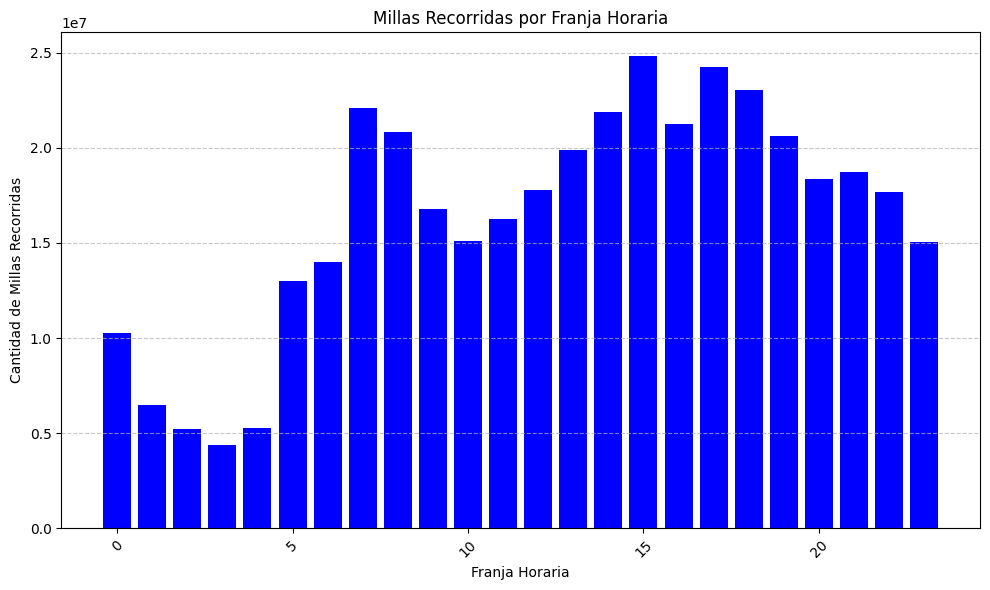

In [ ]:
# Importar las bibliotecas necesarias
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("Visualización de Millas Recorridas por Franja Horaria") \
    .getOrCreate()

# Supongamos que merged_df_sin_nulos es tu DataFrame
# Agrupar por franja horaria y sumar las distancias
aggregated_df = merged_df_sin_nulos.groupBy("franja_horaria") \
    .agg(F.sum("suma_distancias").alias("total_distancias"))

# Recopilar los datos en el lado del cliente
aggregated_data = aggregated_df.toPandas()

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(aggregated_data['franja_horaria'], aggregated_data['total_distancias'], color='blue')
plt.xlabel('Franja Horaria')
plt.ylabel('Cantidad de Millas Recorridas')
plt.title('Millas Recorridas por Franja Horaria')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
